In [2]:
#Here I want to do a quick time series analysis of AllState stock, and maybe Progressive

#Standard Imports

import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_datareader as pdr

#Time series tools
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA


plt.style.use('ggplot')
%matplotlib inline

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1769 entries, 2015-01-02 to 2022-01-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1769 non-null   float64
 1   Low        1769 non-null   float64
 2   Open       1769 non-null   float64
 3   Close      1769 non-null   float64
 4   Volume     1769 non-null   float64
 5   Adj Close  1769 non-null   float64
dtypes: float64(6)
memory usage: 96.7 KB


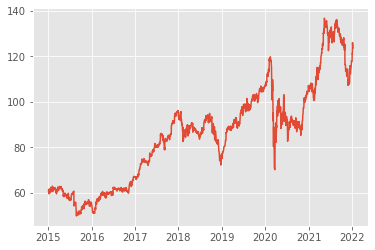

In [3]:
#Let's grab some AllState stock data and plot it

allstate = pdr.get_data_yahoo('ALL',
                          start = dt.datetime(2015, 1, 1),
                          end = dt.datetime(2022, 1, 10))
allstate.info()
allstate.head()

plt.plot(allstate['Adj Close'])
plt.show()

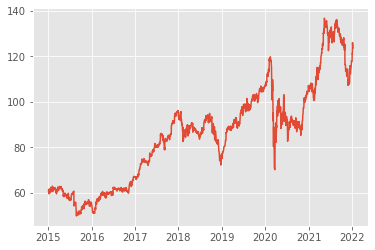

In [4]:
#Now this plot is from 1993 until 2022, so let's go ahead and restrict that data to 2015 onward
allstate = allstate.loc['2015-01-01':,]
allstate.head()
plt.plot(allstate['Adj Close'])
plt.show()


In [5]:
#From here on out, we will look only at the daily adj closing price
#Let's go ahead and check out the basic summary stats

allstate = allstate[['Adj Close']]
allstate.shape
allstate.info()
allstate.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1769 entries, 2015-01-02 to 2022-01-10
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1769 non-null   float64
dtypes: float64(1)
memory usage: 27.6 KB


,Adj Close
count,1769.000000
mean,85.463692
std,21.689731
min,49.872257
25%,62.166939
50%,87.235252
75%,97.808006
max,136.659561


            Adj Close
Date                 
2015-01-02   0.000000
2015-01-05  -0.019823
2015-01-06  -0.000728
2015-01-07   0.016453
2015-01-08   0.019195
...               ...
2022-01-04   0.024182
2022-01-05  -0.000908
2022-01-06   0.011403
2022-01-07   0.029003
2022-01-10  -0.019135

[1769 rows x 1 columns]


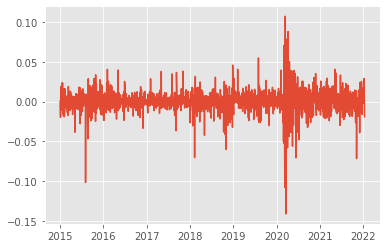

In [6]:
#Looking at daily percent change in the price
daily_pct_change = allstate.pct_change()
daily_pct_change.fillna(0, inplace = True)
print(daily_pct_change)
plt.plot(daily_pct_change)
plt.show()

            Adj Close
Date                 
2015-01-02        NaN
2015-01-05  -0.020022
2015-01-06  -0.000728
2015-01-07   0.016319
2015-01-08   0.019013
...               ...
2022-01-04   0.023894
2022-01-05  -0.000909
2022-01-06   0.011339
2022-01-07   0.028591
2022-01-10  -0.019320

[1769 rows x 1 columns]


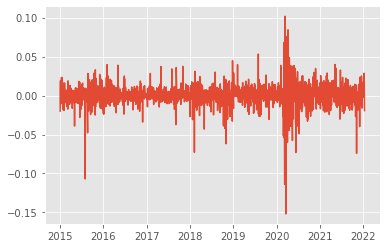

In [7]:
#Looking at daily log returns
daily_log_returns = np.log(allstate.pct_change() + 1)
print(daily_log_returns)
plt.plot(daily_log_returns)
plt.show()

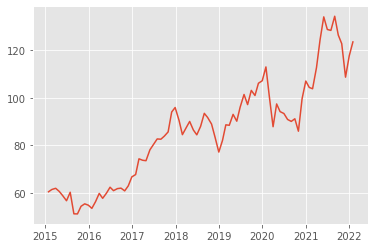

            Adj Close
Date                 
2015-01-30        NaN
2015-02-27   0.015892
2015-03-31   0.008074
2015-04-30  -0.021217
2015-05-29  -0.029270
...               ...
2021-09-30  -0.058915
2021-10-29  -0.028592
2021-11-30  -0.114657
2021-12-31   0.082138
2022-01-31   0.050064

[85 rows x 1 columns]


In [8]:
#Looking at monthly returns
monthly = allstate.resample('BM').apply(lambda x: x[-1])
#BM stands for business months and is slightly different than standard months
plt.plot(monthly)
plt.show()
print(monthly.pct_change())
#This plot is a lot less crowded!

            Adj Close
Date                 
2015-01-31        NaN
2015-05-31   0.001421
2015-09-30  -0.088566
2016-01-31  -0.027718
2016-05-31   0.077580
2016-09-30   0.048875
2017-01-31   0.049199
2017-05-31   0.153355
2017-09-30   0.108458
2018-01-31   0.105673
2018-05-31  -0.033272
2018-09-30   0.017479
2019-01-31  -0.076241
2019-05-31   0.081075
2019-09-30   0.097968
2020-01-31   0.076635
2020-05-31  -0.077467
2020-09-30  -0.060451
2021-01-31   0.072995
2021-05-31   0.190748
2021-09-30   0.117774
2022-01-31  -0.094505


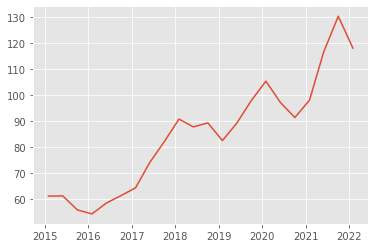

In [9]:
#I want to see the quarterly returns as well, so much is done quarterly
#convert to mean so the object is no longer a resample object, summarizes information, and allows for additional work
quarterly = allstate.resample('4M').mean()
print(quarterly.pct_change())
plt.plot(quarterly)
plt.show() 
#And of course this is much smoother! =)

            Adj Close
Date                 
2015-01-02        NaN
2015-01-05  -0.019823
2015-01-06  -0.000728
2015-01-07   0.016453
2015-01-08   0.019195
...               ...
2022-01-04   0.024182
2022-01-05  -0.000908
2022-01-06   0.011403
2022-01-07   0.029003
2022-01-10  -0.019135

[1769 rows x 1 columns]
            Adj Close
Date                 
2015-01-02        NaN
2015-01-05        NaN
2015-01-06        NaN
2015-01-07  -4.107242
2015-01-08  -3.953102
...               ...
2022-01-04  -3.722148
2022-01-05        NaN
2022-01-06  -4.473869
2022-01-07  -3.540348
2022-01-10        NaN

[1769 rows x 1 columns]


array([[<AxesSubplot:title={'center':'Adj Close'}>]], dtype=object)

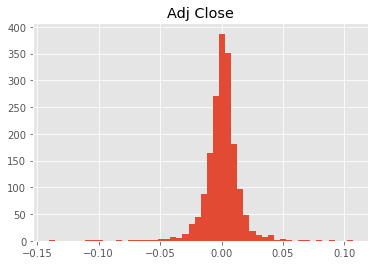

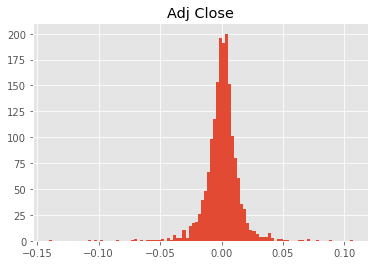

In [10]:
#Time for a more detailed look at the returns

daily_pct_change = allstate / allstate.shift(1) - 1
print(daily_pct_change)

daily_log_returns = np.log(daily_pct_change)
print(daily_log_returns)

daily_pct_change.hist(bins = 50)
daily_pct_change.hist(bins = 100)

            Adj Close
Date                 
2015-01-02        NaN
2015-01-05   0.980177
2015-01-06   0.979463
2015-01-07   0.995579
2015-01-08   1.014689
...               ...
2022-01-04   1.991238
2022-01-05   1.989429
2022-01-06   2.012115
2022-01-07   2.070473
2022-01-10   2.030855

[1769 rows x 1 columns]


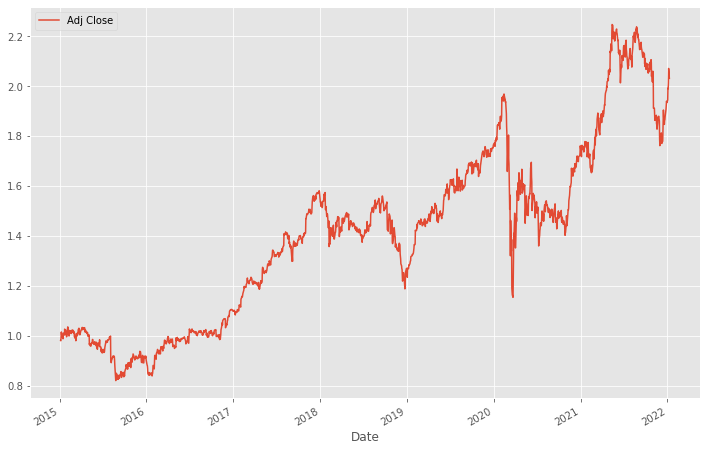

            Adj Close
Date                 
2015-01-31   1.003152
2015-02-28   1.016566
2015-03-31   1.006423
2015-04-30   1.020174
2015-05-31   0.974136
...               ...
2021-09-30   2.141936
2021-10-31   2.072251
2021-11-30   1.892620
2021-12-31   1.847039
2022-01-31   2.006389

[85 rows x 1 columns]


<AxesSubplot:xlabel='Date'>

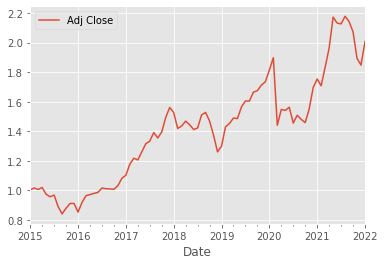

In [11]:
#Now let's take a quick look at cumulative returns
cum_daily_returns = (1 + daily_pct_change).cumprod()
print(cum_daily_returns) #basically would have 12x your money

cum_daily_returns.plot(grid = True, figsize = (12, 8))
plt.show()

#Let's do cum month too
cum_monthly_returns = cum_daily_returns.resample('M').mean()
print(cum_monthly_returns)
cum_monthly_returns.plot(grid = True)

In [12]:
#What have we learned?
#Visually, we see that the allstate price and returns are not normally distributed and increase over time
#This is true for daily, monthly, and quarterly series
#time to go towards some more traditional time series EDA and prediction
#We will use ADF, KPSS, p/acf and ARIMA!

#but for now, let's take a break!

         Adj Close
count  1768.000000
mean      0.000509
std       0.014668
min      -0.140892
25%      -0.005509
50%       0.001030
75%       0.006911
max       0.107041
(1768, 1)


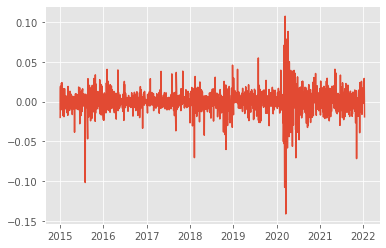

In [13]:
#Okay time for more work, we'll be following the work from that article, which I used as a template for inflation data
print(daily_pct_change.describe())
daily_pct_change = daily_pct_change.dropna()
print(daily_pct_change.shape)
plt.plot(daily_pct_change)
plt.show()

Text(0.5, 1.0, 'Allstate Daily Returns 01/01/2015 - 01/10/2022')

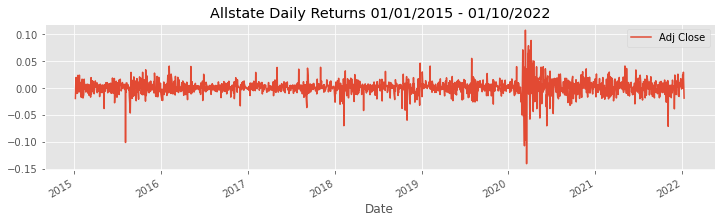

In [14]:
#With 1700+ observations, we should make the training set a bit bigger.
#I think maybe 1 quarter is good, so 252 / 4 = 63 days will be a good prediction window, or test window

#So here is the train test split
train = daily_pct_change.iloc[:-1705, :]
test = daily_pct_change.iloc[-1705:, :]

train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()

daily_pct_change.plot(figsize = (12,3));
plt.title('Allstate Daily Returns 01/01/2015 - 01/10/2022')

In [15]:
#Now we will normalize the data by norm_return = (return - mean) / sd
#This transformation ensures our data is adjusted to a normal distribution
#We'll do a rolling average of....30 days (I am not sure why I chose this, probably because it is one month)

daily_pct_change['norm_return'] = (daily_pct_change['Adj Close'] - daily_pct_change['Adj Close'].rolling(window = 30).mean()) / daily_pct_change['Adj Close'].rolling(window = 30).std()
#Next we do a difference on that!
daily_pct_change['norm_return_diff'] = daily_pct_change['norm_return'] - daily_pct_change['norm_return'].shift(30)
#now we have some detrended data

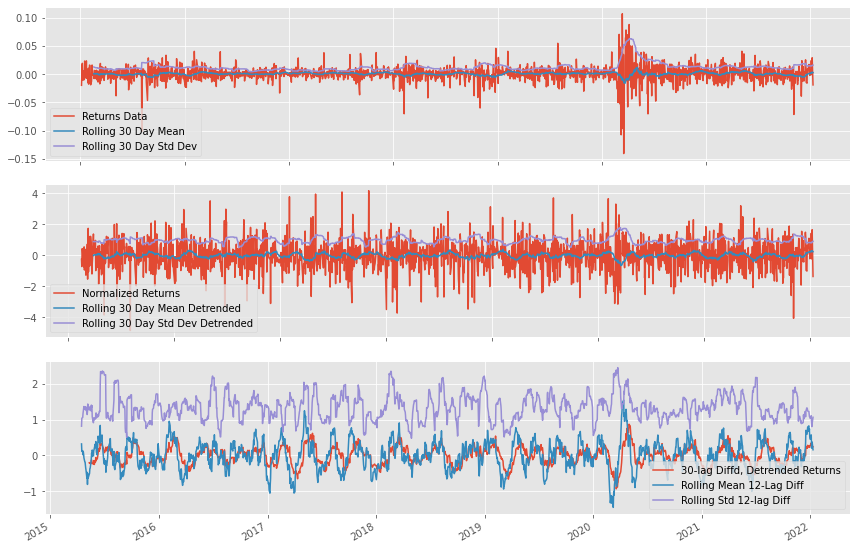

In [16]:
#Now we will define a function to help us plot the data and some ranges

def plot_rolling(df):
    fig, ax = plt.subplots(3, figsize = (12,9))
    
    ax[0].plot(df.index, df['Adj Close'], label = 'Returns Data')
    ax[0].plot(df['Adj Close'].rolling(window = 30).mean(), label = 'Rolling 30 Day Mean')
    ax[0].plot(df['Adj Close'].rolling(window = 30).std(), label = 'Rolling 30 Day Std Dev')
    ax[0].legend()
    
    ax[1].plot(df.index, df.norm_return, label = 'Normalized Returns')
    ax[1].plot(df.norm_return.rolling(window = 30).mean(), label = 'Rolling 30 Day Mean Detrended')
    ax[1].plot(df.norm_return.rolling(window = 30).std(), label = 'Rolling 30 Day Std Dev Detrended')
    ax[1].legend()
    
    ax[2].plot(df.index, df.norm_return_diff.rolling(window = 30).mean(), label = '30-lag Diffd, Detrended Returns')
    ax[2].plot(df.norm_return_diff.rolling(window = 12).mean(), label = 'Rolling Mean 12-Lag Diff')
    ax[2].plot(df.norm_return_diff.rolling(window = 12).std(), label = 'Rolling Std 12-lag Diff')
    ax[2].legend()
    
    plt.tight_layout()
    fig.autofmt_xdate()
    
#So this function plots the returns day, rolling 30 day stats, then it plots the normalized data and rolling detrend
#then it plots the norm returns diff 30 lag returns

plot_rolling(daily_pct_change)
#As you can see, the normalized detrended data looks a lot cleaner than the returns, and the same goes for the 30 lag

In [17]:
#Time for time series tests - ADF first
"""Augmented Dickey Fuller:
    H_0: Gamma = 0 (A unit root exists in the data)
    H_A: Gamma < 0 (A unit root does not exist in the data)
    
    If a unit root exists in the data, the series is NOT stationary.
    The more negative the test statistic, the stronger the rejection of the null.
    If the p-value for the test statistic is below a given level of confidence,
    then at that level of confidence, we can reject the null hypothesis.
    We can then conclude that the series does not exist in the data, the data is stationary 
    (most likely).
"""

#Straight daily_pct_change first

def dftest(df, column):
    test = adfuller(df[column].dropna(), autolag = 'AIC')
    print('Test statistic = {:.3f}'.format(test[0]))
    print('p-value = {:.3f}'.format(test[1]))
    print('Critical values: ')
    for k,v in test[4].items():
        print('\t{}: {} - The data is {} stationary with {}% conf.'.\
          format(k, v, 'not' if v < test[0] else "", 100 -int(k[:-1])))

print('Are the returns stationary?')
dftest(daily_pct_change, 'Adj Close')

print('Are the normalized returns staionary?')
dftest(daily_pct_change, 'norm_return')

print('Is the 30-Lag Diffd, de-trended norm_return_diff data stationary?')
dftest(daily_pct_change, 'norm_return_diff')

#All three series are stationary!! Yay!

Are the returns stationary?
Test statistic = -10.247
p-value = 0.000
Critical values: 
	1%: -3.4341094501874854 - The data is  stationary with 99% conf.
	5%: -2.8632005876775297 - The data is  stationary with 95% conf.
	10%: -2.567654048515701 - The data is  stationary with 90% conf.
Are the normalized returns staionary?
Test statistic = -45.017
p-value = 0.000
Critical values: 
	1%: -3.4341181153766156 - The data is  stationary with 99% conf.
	5%: -2.863204412766938 - The data is  stationary with 95% conf.
	10%: -2.5676560852851247 - The data is  stationary with 90% conf.
Is the 30-Lag Diffd, de-trended norm_return_diff data stationary?
Test statistic = -43.705
p-value = 0.000
Critical values: 
	1%: -3.4341843999399573 - The data is  stationary with 99% conf.
	5%: -2.8632336725104834 - The data is  stationary with 95% conf.
	10%: -2.567671665464627 - The data is  stationary with 90% conf.


In [18]:
#Now it's time for the KPSS Test!

"""The article mentions KPSS test but does not implement it.
I found the tutorial on statsmodels and I will use a function
that is written there for my KPSS test. Just a reminder, I will go back at a later date
and use the ADF test function that is included in the same location.

What is the statement of the KPSS?

H_0: The series is trend-stationary
H_A: The series has a unit root, the series is not stationary.

This is different than the ADF test in the hypotheses, and the outcomes.
Here, if the p-value is less than our confidence interval, we reject the null
that the series IS trend-stationary. This means we believe the alternative, 
that the series is not stationary.
That's opposite of the ADF test whose null is the series is not stationary.

The tests also are not interchangeable, here's a breakdown from statsmodels


Case 1: Both tests conclude that the series is not stationary - The series is not stationary
Case 2: Both tests conclude that the series is stationary - The series is stationary
Case 3: KPSS indicates stationarity and ADF indicates non-stationarity-
    The series is trend stationary. Trend needs to be removed to make series strict stationary. 
    The detrended series is checked for stationarity.
Case 4: KPSS indicates non-stationarity and ADF indicates stationarity-
    The series is difference stationary. Differencing is to be used to make series stationary. 
    The differenced series is checked for stationarity.
"""

def kpss_test(timeseries):
    print("Results of KPSS Test: ")
    kpsstest = kpss(timeseries, regression = 'c', nlags = 'auto')
    kpss_output = pd.Series(
        kpsstest[0:3], index = ['Test statistic', 'p-value', 'Lags Used'])
    for k,v in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % k] = v
    print(kpss_output)

print('Does the return data pass the KPSS test?')
kpss_test(daily_pct_change['Adj Close'].dropna())

print('Do the normalized returns, detrended, pass the KPSS test?')
kpss_test(daily_pct_change.norm_return.dropna())

print('Do the 30 lag normalized returns, detrended, pass the KPSS test?')
kpss_test(daily_pct_change.norm_return_diff.dropna())

#The results show a p-value of 0.10
#This means that at our levels of confidence, we DO NOT REJECT the null hypotheses
#And we conclude that series ARE trend-stationary.

Does the return data pass the KPSS test?
Results of KPSS Test: 
Test statistic            0.042163
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Do the normalized returns, detrended, pass the KPSS test?
Results of KPSS Test: 
Test statistic            0.012899
p-value                   0.100000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Do the 30 lag normalized returns, detrended, pass the KPSS test?
Results of KPSS Test: 
Test statistic           0.011349
p-value                  0.100000
Lags Used                0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: fl

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


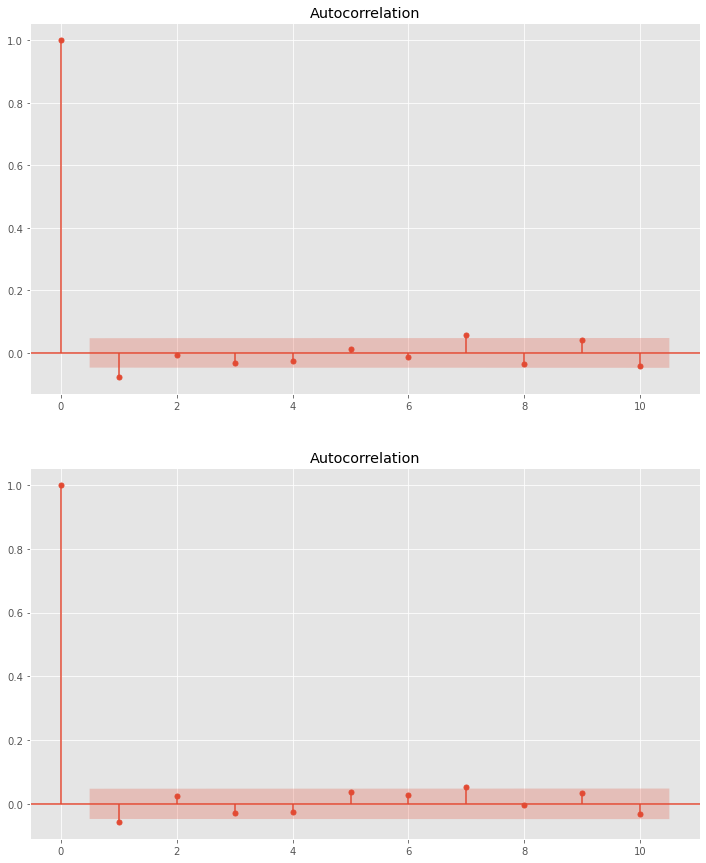

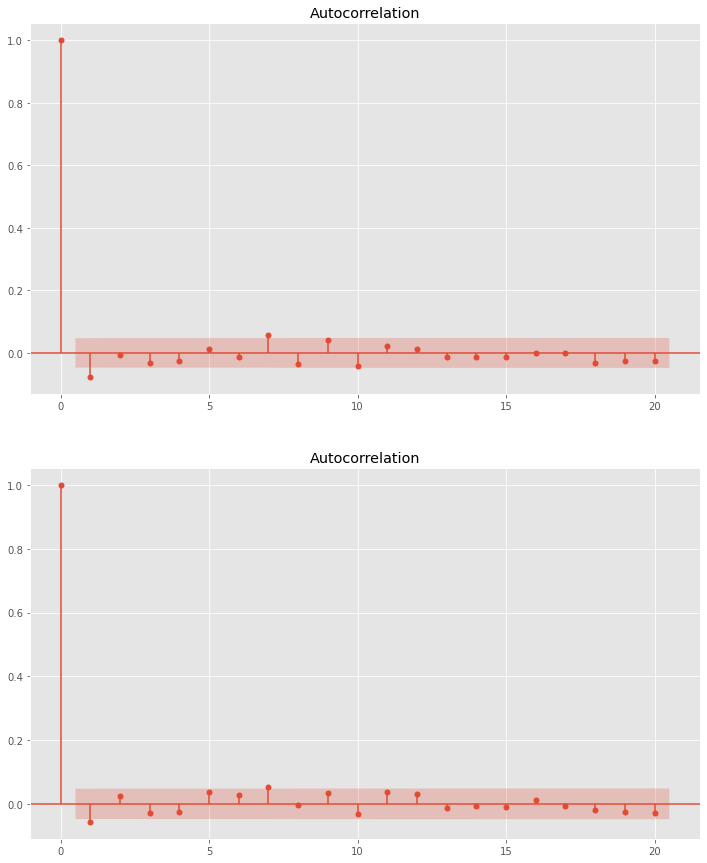

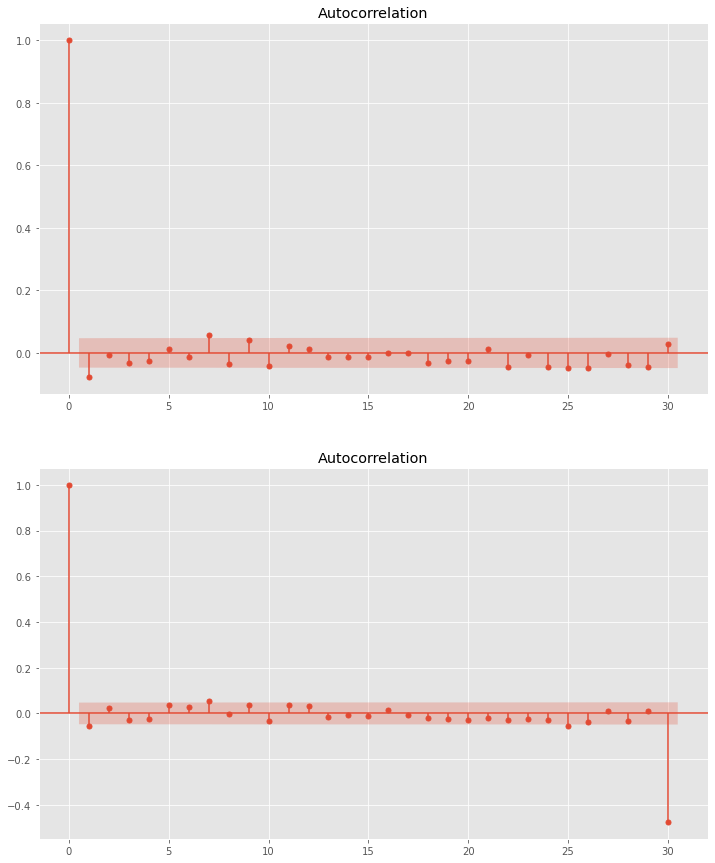

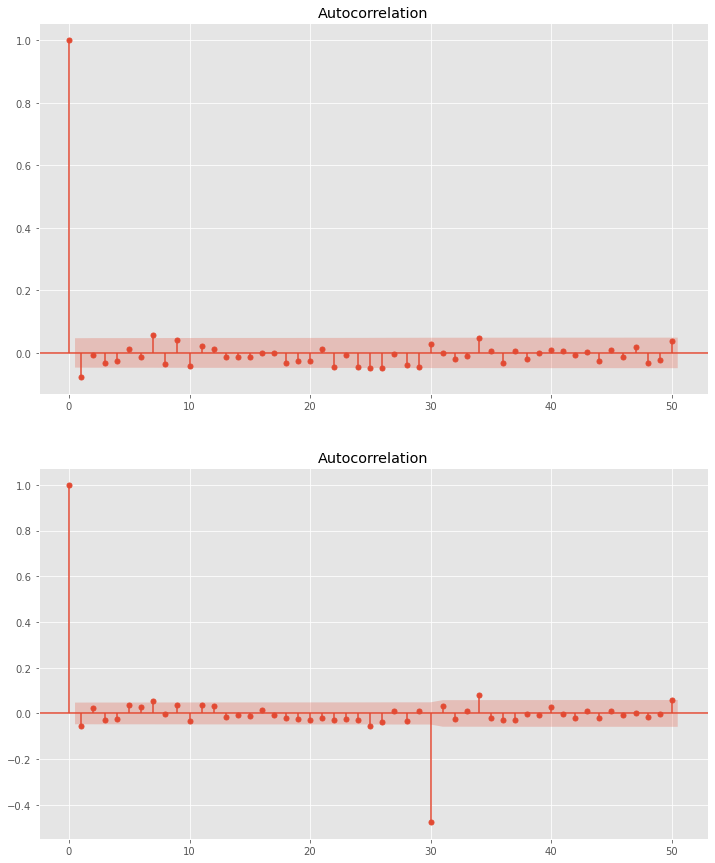

In [19]:
#Time for ACF and PACF

# Autocorrelation measures the autcorr of the series with its own lags
# Partial AC shows the amount of correlation that is not explained by
# correlations at all lower-order lags
# We do this via a plot first


for lag in [10, 20, 30, 50]:
    fig, ax = plt.subplots(2, figsize = (12, 15))
    ax[0] = plot_acf(daily_pct_change.norm_return.dropna(), ax = ax[0], lags = lag)
    ax[1] = plot_acf(daily_pct_change.norm_return_diff.dropna(), ax = ax[1], lags = lag)
    
#These lags are curious. I will look at them another time

In [20]:
"""Choosing a model

Exponential smoothing methods are great for non-stationary data (exhibiting trend or seasonal parttern)
    These arise as different kinds of weighted averages
ARIMA methods should be used only for stationary data.
    Remove the trend by deflating or logging, then look at the differenced data.
"""

#When to use Simple Exponential Smoothing?
# Few data points, irregular data, no seasonality or trend

#Holt's Linear Exp Smoothing
# Use when the data has trend but no seasonality

# ************NOTE*****************
# WE HAVE TO REDEFINE TRAIN TEST SPLIT BECAUSE OF HOW THE ARTICLE FLOWS

#Simple Exp Smooth: Basic train/test/split
# Then fit pred

#We will be using Adj Close
#the train test split gives 63 observations for forecast/prediction
#if you would like to check that, use allstate_new.shape[0] - test.shape[0]

allstate_new = daily_pct_change.drop(['norm_return', 'norm_return_diff'], axis = 1)
allstate_new = allstate_new.resample("D").sum() 

train = allstate_new.iloc[:1705, :]
test = allstate_new.iloc[-63:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()


In [21]:
#Create and fit a Simple Exponential Smoothing (SES) model

ses_model = SimpleExpSmoothing(np.asarray(train['Adj Close']))
ses_model._index = pd.to_datetime(train.index)

fit1 = ses_model.fit()
pred1 = fit1.forecast(63)

fit2 = ses_model.fit(smoothing_level = .2)
pred2 = fit2.forecast(63)

fit3 = ses_model.fit(smoothing_level = .5)
pred3 = fit3.forecast(63)

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


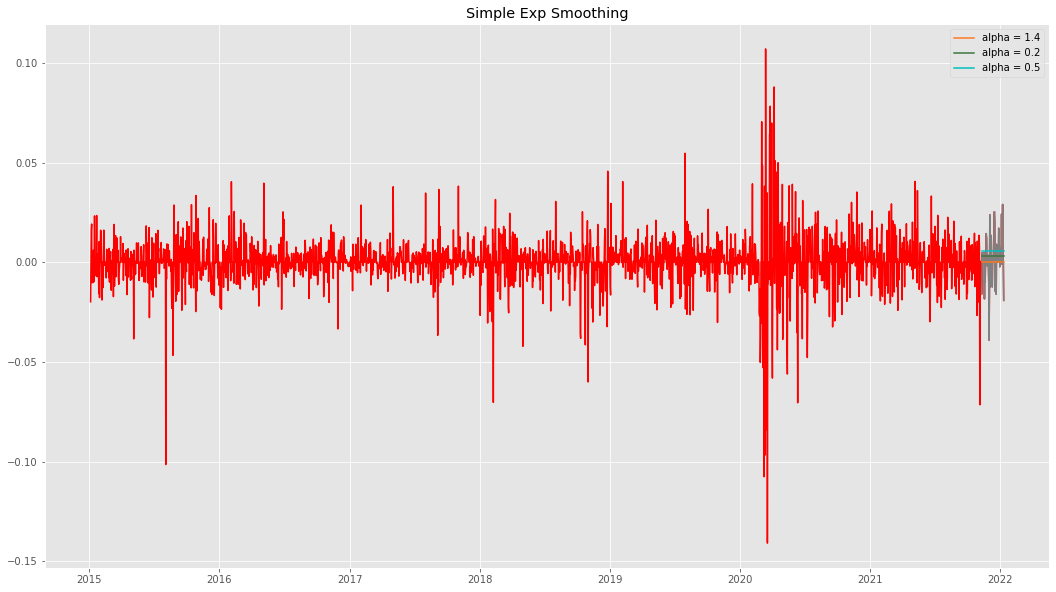

In [22]:
#Plot
#I made this plot bigger than (12,6) so we can get a better view of the models,
#Yet only fit3 shows up

fig, ax = plt.subplots(figsize = (18,10))
ax.plot(allstate_new[:2563], color = 'red')
ax.plot(train.index[2563:], train.values[2563:])
ax.plot(test.index, test.values, color = 'gray')
for p, f, c in zip((pred1, pred2, pred3), (fit1, fit2, fit3), ('#ff7823','#3c763d','c')):
    ax.plot(train.index[2563:], f.fittedvalues[2563:], color = c)
    ax.plot(test.index, p, label = 'alpha = ' + str(f.params['smoothing_level'])[:3], color = c)
plt.title('Simple Exp Smoothing')
plt.legend();
#So this plot needs a lot of work, but the point is on the right there, SES is not a good model for this data

In [23]:
#Okay, now it is time for Holt's model

holt_model = Holt(np.asarray(allstate_new['Adj Close']))
holt_model._index = pd.to_datetime(train.index)

fit1 = holt_model.fit(smoothing_level = 0.3, smoothing_trend = 0.05)
pred1 = fit1.forecast(63)

fit2 = holt_model.fit(optimized = True)
pred2 = fit2.forecast(63)

fit3 = holt_model.fit(smoothing_level = 0.3, smoothing_trend = 0.2)
pred3 = fit3.forecast(63)

print(fit1.sse)
print(fit2.sse)
print(fit3.sse)
#From this output fit3 performed the best!!!

0.46807190533208143
0.38028905039278693
0.5091370381637748


C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


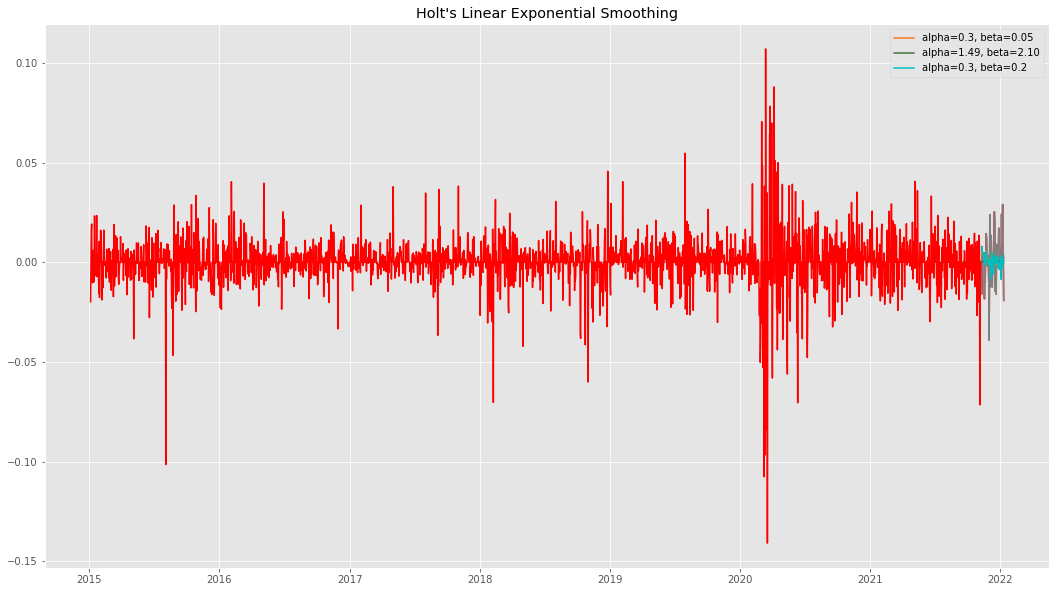

In [24]:
#And we will get a very similar plot here:
#It seems then that fit3 has performed the best so far!
#And still, it is the only model which shows up. Maybe I should play with opacity

fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(allstate_new[:2563], color = 'red')
ax.plot(train.index[2563:], train.values[2563:])
ax.plot(test.index, test.values, color = 'gray')
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[2563:], f.fittedvalues[2563:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4], color=c)
plt.title("Holt's Linear Exponential Smoothing")
plt.legend();


In [26]:
#Next up, Holt's Dampened Trend

#Model 1 no dampening
model1 = ExponentialSmoothing(np.asarray(train['Adj Close'] + 0.5), trend = 'mul', seasonal = None)
model1._index = pd.to_datetime(train.index)

#model2 the dampening --- damped = True
model2 = ExponentialSmoothing(np.asarray(train['Adj Close'] + 0.5), trend = 'mul', seasonal = None, damped_trend = True)
model2._index = pd.to_datetime(train.index)

fit1 = model1.fit()
fit2 = model2.fit()
pred1 = fit1.forecast(63) - 0.5
pred2 = fit2.forecast(63) - 0.5

#Let's try a model 3 which uses seasonal = 'add' and then = 'mul'
model3 = ExponentialSmoothing(np.asarray(train['Adj Close'] + 0.5), trend = 'mul', seasonal = 'add', seasonal_periods = 5, damped_trend = True)
model3._index = pd.to_datetime(train.index)

model4 = ExponentialSmoothing(np.asarray(train['Adj Close'] + 0.5), trend = 'mul', seasonal = 'mul', seasonal_periods = 5, damped_trend = True)
model4._index = pd.to_datetime(train.index)

fit3 = model4.fit()
pred3 = fit3.forecast(63) - 0.5
fit4 = model4.fit()
pred4 = fit4.forecast(63) - 0.5

print(fit1.sse)
print(fit2.sse)
print(fit3.sse)
print(fit4.sse)

#From this output, fit2 performed the best!
#But look at Holt again. Holt's model fit3 reached 0.5091365272647903 which is wayyy better than the fit score of 
#0.14523674709164536
#wow!! Yeah Holt!

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\holtwinters\model.py:42

0.14536444788636743
0.14523649924294085
0.1448823084534278
0.1448823084534278


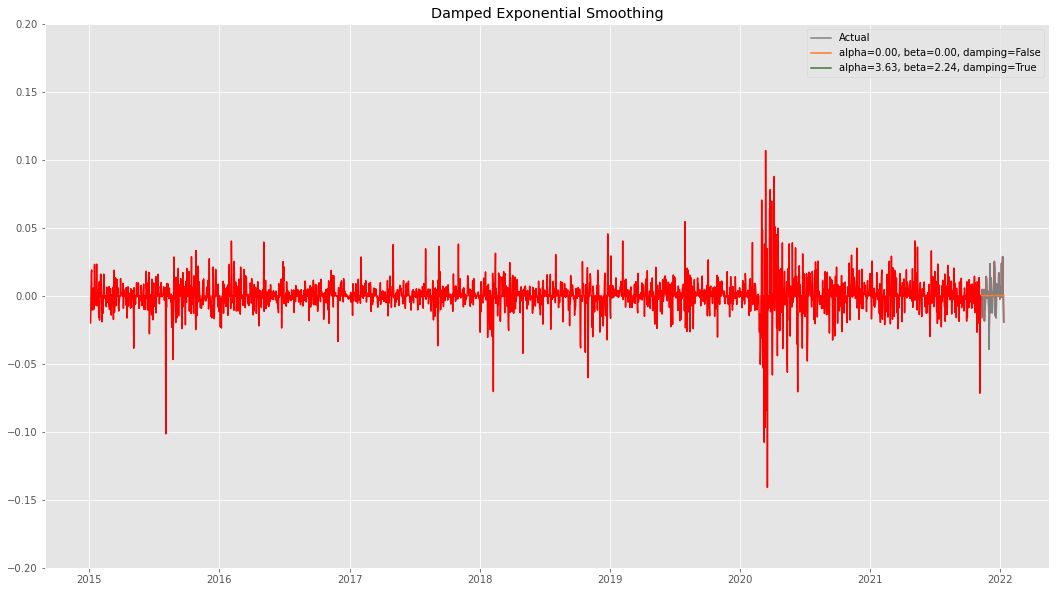

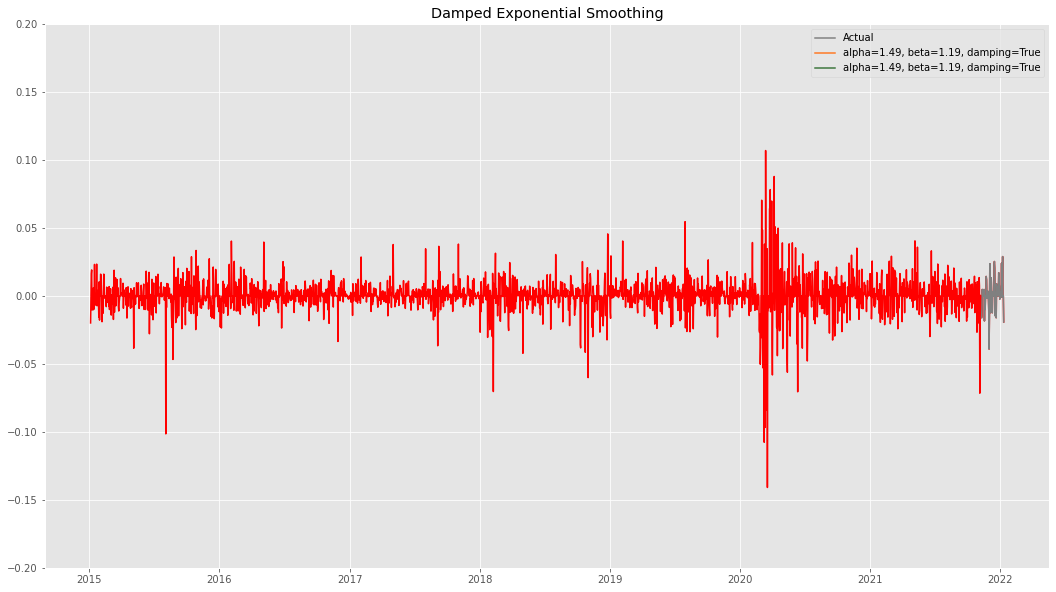

In [27]:
#Time to plot

fig, ax = plt.subplots(figsize = (18,10))
ax.plot(allstate_new[:2563], color = 'red')

ax.plot(train.index[2563:], train.values[2563:])
ax.plot(test.index, test.values, color = 'gray', label = 'Actual')

for f, p, c in zip((fit1, fit2), (pred1, pred2), ('#ff7823','#3c763d')):
    ax.plot(train.index[2563:], f.fittedvalues[2563:], color = c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4]+ ", damping="+str(True if f.params['damping_trend']>0 else False), color=c)
plt.ylim(-.2,.2)    
ax.set_title("Damped Exponential Smoothing");
plt.legend();


##Plots for models 3 and 4
fig, ax = plt.subplots(figsize = (18,10))
ax.plot(allstate_new[:2563], color = 'red')

ax.plot(train.index[2563:], train.values[2563:])
ax.plot(test.index, test.values, color = 'gray', label = 'Actual')

for f, p, c in zip((fit3, fit4), (pred3, pred4), ('#ff7823','#3c763d')):
    ax.plot(train.index[2563:], f.fittedvalues[2563:], color = c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4]+ ", damping="+str(True if f.params['damping_trend']>0 else False), color=c)
plt.ylim(-.2,.2)    
ax.set_title("Damped Exponential Smoothing");
plt.legend();

#looking at the demped smoothing models without seasonality, they are not the best
#but the seasonal models are far better, seasonal periods = 5 for 5 day trading weeks
#cannot even see the predictions for models and plots 3,4

Text(0.5, 1.0, 'Logged Adj Close')

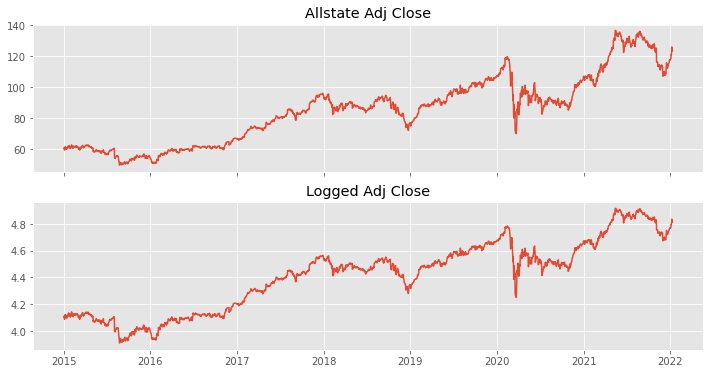

In [30]:
"""Time for ARIMA!"""

#Let's plot some data
#allstate_new.info()
#allstate_new.head()

fig, ax = plt.subplots(2, sharex = True, figsize = (12,6))
ax[0].plot(allstate['Adj Close'])
ax[0].set_title("Allstate Adj Close")
ax[1].plot(np.log(allstate['Adj Close']))
ax[1].set_title("Logged Adj Close")

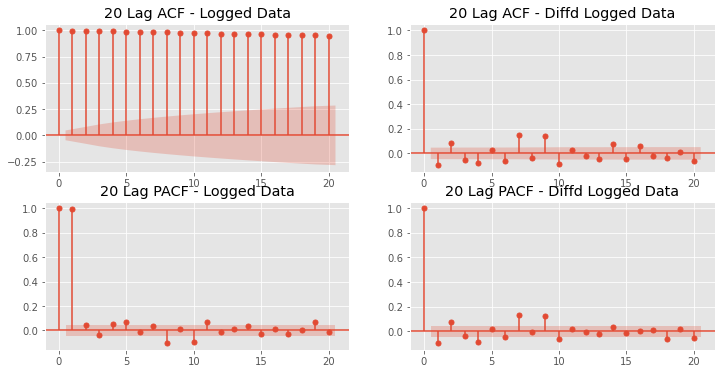

In [32]:
#Let's plot autocorrelations now to see what those look like

first_diff = (np.log(allstate['Adj Close']) - np.log(allstate['Adj Close']).shift()).dropna()

fig, ax = plt.subplots(2,2, figsize = (12,6))
ax[0, 0] = plot_acf(np.log(allstate['Adj Close']), ax = ax[0,0], lags = 20, title = '20 Lag ACF - Logged Data')
ax[1, 0] = plot_pacf(np.log(allstate['Adj Close']), ax = ax[1, 0], lags = 20, title = '20 Lag PACF - Logged Data')
ax[0, 1] = plot_acf(first_diff, ax = ax[0, 1], lags = 20, title = '20 Lag ACF - Diffd Logged Data')
ax[1, 1] = plot_pacf(first_diff, ax = ax[1, 1], lags = 20, title = '20 Lag PACF - Diffd Logged Data')

#These autocorrelations look pretty severe. My suspicion is that more differences will be needed for accurate results.

In [33]:
#Now let's check for stationarity.

print("Is our data stationary? ")
kpsstest = kpss(np.log(allstate['Adj Close']), 'ct')
print('Test statistic = {:.3f}'.format(kpsstest[0]))
print('P-value = {:.3f}'.format(kpsstest[1]))
print('Critical values : ')
for k, v in kpsstest[3].items():
    print('\t{}: {}'.format(k,v))

#Since our test statistic is greater than the p-value, we reject the null hypothesis, that the series is trend stationary,
#concluding that it has a unit root and is not stationary

Is our data stationary? 
Test statistic = 0.368
P-value = 0.010
Critical values : 
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [35]:
#Now let's do ADF! 

dftest = adfuller(np.log(allstate['Adj Close']), autolag = 'AIC')
print('Test statistic = {:.3f}'.format(dftest[0]))
print('p-value = {:.3f}'.format(dftest[1]))
print('Critical values: ')
for k,v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% conf.'.\
          format(k, v, 'not' if v < dftest[0] else "", 100 -int(k[:-1])))
    
#here we must conclude that the data is not stationary
#Note that this is only for the raw series, with no differencing.

#Since both tests agree that the data is not stationary, we can conclude it is not stationary

Test statistic = -0.777
p-value = 0.826
Critical values: 
	1%: -3.434102977404239 - The data is not stationary with 99% conf.
	5%: -2.8631977303784235 - The data is not stationary with 95% conf.
	10%: -2.5676525270728483 - The data is not stationary with 90% conf.


In [40]:
#Let's now check KPSS and ADF on the first_diff set of data

print("Is our data stationary? ")
kpsstest = kpss(first_diff, 'ct')
print('Test statistic = {:.3f}'.format(kpsstest[0]))
print('P-value = {:.3f}'.format(kpsstest[1]))
print('Critical values : ')
for k, v in kpsstest[3].items():
    print('\t{}: {}'.format(k,v))
    
#The results here suggest that the data is stationary, the test stat is less than the p value
#Now to see if ADF agrees

dftest = adfuller(first_diff, autolag = 'AIC')
print('Test statistic = {:.3f}'.format(dftest[0]))
print('p-value = {:.3f}'.format(dftest[1]))
print('Critical values: ')
for k,v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% conf.'.\
          format(k, v, 'not' if v < dftest[0] else "", 100 -int(k[:-1])))
    
#Would you look at that?! The first_diff series is stationary. Note that this data has been logged and differenced


Is our data stationary? 
Test statistic = 0.034
P-value = 0.100
Critical values : 
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
Test statistic = -10.110
p-value = 0.000
Critical values: 
	1%: -3.4341094501874854 - The data is  stationary with 99% conf.
	5%: -2.8632005876775297 - The data is  stationary with 95% conf.
	10%: -2.567654048515701 - The data is  stationary with 90% conf.


C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                 1768
Model:                     ARMA(0, 0)   Log Likelihood                4942.525
Method:                           css   S.D. of innovations              0.015
Date:                Sun, 06 Feb 2022   AIC                          -9881.050
Time:                        13:17:23   BIC                          -9870.095
Sample:                             0   HQIC                         -9877.002
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.140      0.254      -0.000       0.001
                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observat

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

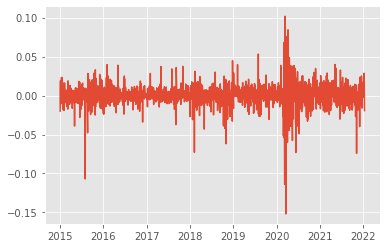

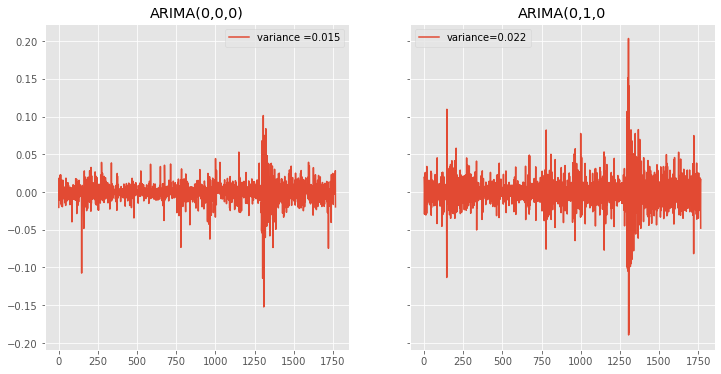

In [45]:
#Time for ARIMA!!!
#model fit predict

# (p,d,q) = 0,0,0
model_000 = ARIMA(first_diff.dropna(), (0,0,0))
res_000 = model.fit()
print(res_000.summary())


#(p, d, q) = 0,1,0
model_010 = ARIMA(first_diff.dropna(), (0,1,0))
res_010 = model_010.fit()
print(res_010.summary())

#In the results, take a look at AIC. The lower it is, the better that model performs

#Plot the new series

plt.plot(first_diff)

fig, ax = plt.subplots(1, 2, sharey = True, figsize = (12,6))
ax[0].plot(res_000.resid.values, label = 'variance ={:.3f}'.format(np.std(res_000.resid.values)))
ax[0].set_title('ARIMA(0,0,0)')
ax[0].legend()

ax[1].plot(res_010.resid.values, label = 'variance={:.3f}'.format(np.std(res_010.resid.values)))
ax[1].set_title('ARIMA(0,1,0)')
ax[1].legend()



                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                 1768
Model:                     ARMA(1, 0)   Log Likelihood                4950.667
Method:                       css-mle   S.D. of innovations              0.015
Date:                Sun, 06 Feb 2022   AIC                          -9895.335
Time:                        13:33:53   BIC                          -9878.902
Sample:                             0   HQIC                         -9889.263
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0004      0.000      1.261      0.207      -0.000       0.001
ar.L1.Adj Close    -0.0958      0.024     -4.045      0.000      -0.142      -0.049
                                

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

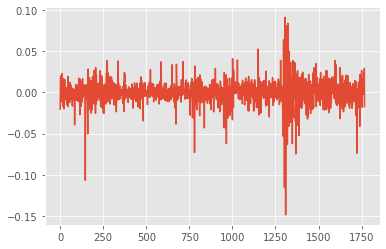

In [61]:
#Let's see how things look when using moore than p,d,q = (0,1,0)

model_100 = ARIMA(first_diff, (1, 0, 0))
res_100 = model_100.fit()
print(res_100.summary())
#Model 100 gives AIC of -9895.335

plt.plot(res_100.resid.values)


                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 1767
Model:                 ARIMA(1, 1, 0)   Log Likelihood                4610.102
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 06 Feb 2022   AIC                          -9214.205
Time:                        13:34:17   BIC                          -9197.774
Sample:                             1   HQIC                         -9208.134
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              6.349e-06      0.000      0.024      0.981      -0.001       0.001
ar.L1.D.Adj Close    -0.5813      0.019    -29.983      0.000      -0.619      -0.543
                        

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

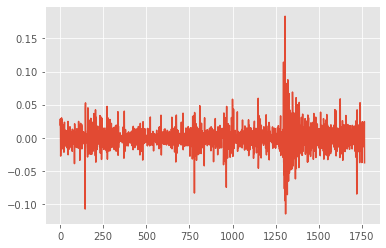

In [62]:
model_110 = ARIMA(first_diff, (1, 1,0))
res_110 = model_110.fit()
print(res_110.summary())
#Model 110 gives AIC of -9214.205
plt.plot(res_110.resid.values)


                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                 1768
Model:                     ARMA(0, 1)   Log Likelihood                4949.630
Method:                       css-mle   S.D. of innovations              0.015
Date:                Sun, 06 Feb 2022   AIC                          -9893.260
Time:                        13:34:22   BIC                          -9876.827
Sample:                             0   HQIC                         -9887.188
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0004      0.000      1.255      0.209      -0.000       0.001
ma.L1.Adj Close    -0.0841      0.022     -3.771      0.000      -0.128      -0.040
                                

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

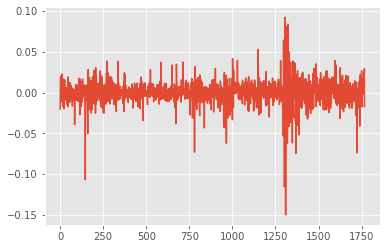

In [63]:
model_001 = ARIMA(first_diff, (0, 0, 1))
res_001 = model_001.fit()
print(res_001.summary())
#Model 001 gives AIC of -9893.260
plt.plot(res_001.resid.values)


                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                 1768
Model:                     ARMA(1, 1)   Log Likelihood                4954.006
Method:                       css-mle   S.D. of innovations              0.015
Date:                Sun, 06 Feb 2022   AIC                          -9900.011
Time:                        13:35:21   BIC                          -9878.101
Sample:                             0   HQIC                         -9891.916
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0004      0.000      1.238      0.216      -0.000       0.001
ar.L1.Adj Close    -0.4659      0.100     -4.642      0.000      -0.663      -0.269
ma.L1.Adj Close     0.3646      

C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

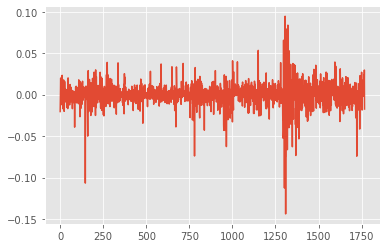

In [64]:
#Let's do a few more

model_101 = ARIMA(first_diff, (1,0,1))
res_101 = model_101.fit()
print(res_101.summary())
#Model_101 gives AIC of -9900.011
#This is the best model so far, let's do 2 more
plt.plot(res_101.resid.values)



C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 1767
Model:                 ARIMA(1, 1, 1)   Log Likelihood                4942.510
Method:                       css-mle   S.D. of innovations              0.015
Date:                Sun, 06 Feb 2022   AIC                          -9877.020
Time:                        13:35:26   BIC                          -9855.111
Sample:                             1   HQIC                         -9868.925
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.862e-07    1.4e-06      0.204      0.838   -2.46e-06    3.03e-06
ar.L1.D.Adj Close    -0.0960      0.024     -3.996      0.000      -0.143      -0.049
ma.L1.D.Adj Close    -0.

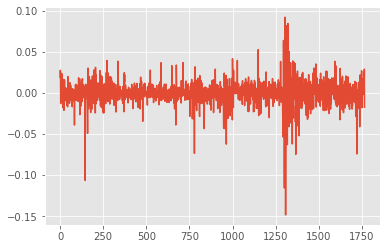

In [65]:
model_111 = ARIMA(first_diff, (1,1,1))
res_111 = model_111.fit()
print(res_111.summary())
#AIC of -9877.020, slightly worse than the best
plt.plot(res_111.resid.values)


                             ARIMA Model Results                              
Dep. Variable:           D2.Adj Close   No. Observations:                 1766
Model:                 ARIMA(0, 2, 0)   Log Likelihood                3229.100
Method:                           css   S.D. of innovations              0.039
Date:                Sun, 06 Feb 2022   AIC                          -6454.200
Time:                        13:35:29   BIC                          -6443.247
Sample:                             2   HQIC                         -6450.153
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.806e-05      0.001     -0.041      0.967      -0.002       0.002


C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

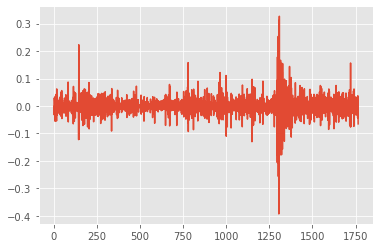

In [66]:

#And lastly, let's see about 2 differences!

model_020 = ARIMA(first_diff, (0, 2, 0))
res_020 = model_020.fit()
print(res_020.summary())
#AIC of -6454.200, so not even close. The best model is model_101.
plt.plot(res_020.resid.values)


C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Anaconda3\envs\fin_py\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

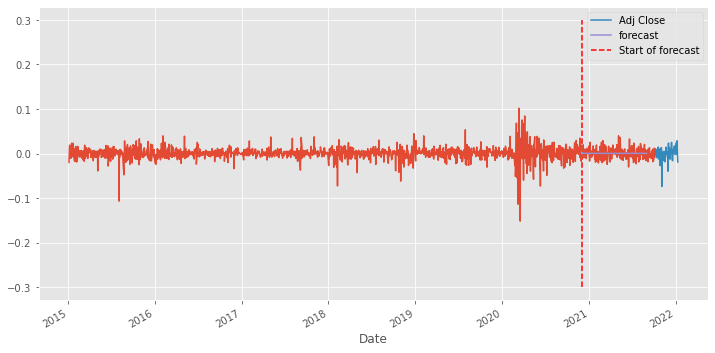

In [92]:
model = ARIMA(first_diff[:-20],(1,0,1))
res_101 = model.fit()

fig, ax = plt.subplots(figsize = (12,6))
ax.plot(first_diff[:1705])
first_diff.index = pd.to_datetime(first_diff.index, format="%Y-%m")
first_diff[1705:].plot(ax=ax)
ax.vlines('2020-12', ymin = -0.3, ymax = 0.3, linestyle='--', color='r', label='Start of forecast');

# - NOTE from the official matplotlib documentation :
# -- The dynamic keyword affects in-sample prediction. 
# -- If dynamic is False, then the in-sample lagged values are used for prediction. 
# -- If dynamic is True, then in-sample forecasts are used in place of lagged dependent variables.

ax = res_101.plot_predict('2020-12', '2021-09', dynamic = True, plot_insample = False, ax = ax)